### 1. Load History OHCLV 

create a new terminal and 

Download-data: 
`
freqtrade download-data --config user_data/config.json --timeframe 15m --timerange 20240101-20250101
`

File-like:
`
BTC_USDT-15m.feather
`


In [28]:
import pandas as pd 
import os
import re
import warnings
warnings.filterwarnings("ignore")
import sys
sys.path.append('../../')

file_path = '../../../freqtrade/user_data/data/binance/'
time_frame = '1d'

def extract_coin_symbols(directory):
    coin_list = []
    pattern = re.compile(r'(.+?)_USDT-1d\.feather$')

    for filename in os.listdir(directory):
        match = pattern.match(filename)
        if match:
            coin_symbol = (match.group(1)+'/USDT').replace('_','/')
            coin_list.append(coin_symbol)
    return coin_list


if os.path.exists(file_path) and os.path.isdir(file_path):
    coins = extract_coin_symbols(file_path)
len(coins)

401

### 2. Pair Filter

In [29]:
import random
target_coins = coins
# target_coins = random.sample(target_coins, 2)
# target_coins =['BTC/USDT','ETH/USDT','XRP/USDT']

len(target_coins)

401

### 3. Load History OHLCV 

In [30]:
def extract_coin_data(directory):
    coin_list = {}
    symbols = []
    pattern = re.compile(r'(.+?)_USDT-1d\.feather$')

    for filename in os.listdir(directory):
        match = pattern.match(filename)
        if match:
            coin_symbol = (match.group(1)+'/USDT').replace('_','/')
            if coin_symbol in target_coins: 
                df = pd.read_feather(f'{directory}/{filename}')
                df = df.reset_index(drop=True)
                if len(df) > 0 :
                    coin_list[coin_symbol] = df
                    symbols.append(coin_symbol)
    
    return coin_list,symbols

if os.path.exists(file_path) and os.path.isdir(file_path):
    coins,symbols = extract_coin_data(file_path)
print(len(coins))

401


### 3. History Data Transform

In [31]:
import pandas as pd
close_dfs = []

for symbol, df in coins.items():
    
    temp_df = df[['date', 'close']].copy()
    temp_df['date'] = pd.to_datetime(temp_df['date'])
    temp_df = temp_df.set_index('date')  # 将date设为索引
    # temp_df.index = temp_df.index.tz_localize(None)
    temp_df.columns = [symbol]  
    close_dfs.append(temp_df)


close = pd.concat(close_dfs, axis=1)
close.head()

,BTC/USDT,ETH/USDT,BNB/USDT,NEO/USDT,LTC/USDT,QTUM/USDT,ADA/USDT,XRP/USDT,EOS/USDT,TUSD/USDT,...,VIRTUAL/USDT,KERNEL/USDT,WCT/USDT,HYPER/USDT,INIT/USDT,SIGN/USDT,STO/USDT,SYRUP/USDT,KMNO/USDT,SXT/USDT
date,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00+00:00,3797.14,139.10,5.9910,7.756,31.48,2.229,0.04198,0.36080,2.6184,0.9932,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-02 00:00:00+00:00,3858.56,152.01,6.0510,7.899,32.67,2.309,0.04433,0.36882,2.8197,0.9925,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-03 00:00:00+00:00,3766.78,146.30,5.7979,7.522,31.39,2.160,0.04205,0.35240,2.6379,0.9951,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-04 00:00:00+00:00,3792.01,151.97,5.9692,7.455,31.76,2.205,0.04301,0.35308,2.6744,0.9921,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-05 00:00:00+00:00,3770.96,152.83,5.9625,7.722,34.33,2.205,0.04403,0.34851,2.6510,0.9933,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 4. OHLCV Filter

After Filter Shape : (494, 327)


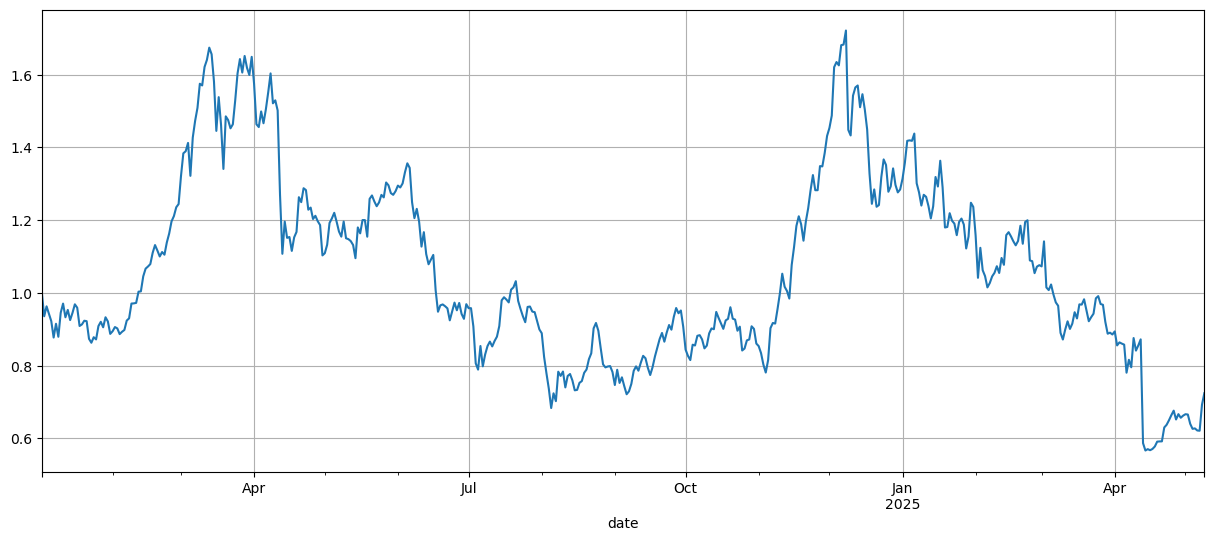

In [32]:
close_filter_date = close[close.index > '2024-01-01']
# close_filter_date = close[close.index < '2025-04-30']

null_counts = close_filter_date.isnull().sum()
null_percentages = (close_filter_date.isnull().mean() * 100).round(2)
null_summary = pd.DataFrame({
    'Null Count': null_counts,
    'Null Percentage (%)': null_percentages
})
filter_pairs = (null_summary[null_summary['Null Percentage (%)']>35].index.to_list())

close_filter_null = close_filter_date.drop(columns=[col for col in filter_pairs if col in close_filter_date.columns])



close_filter = close_filter_null
print(f'After Filter Shape : {close_filter.shape}')
df_norm = close_filter/close_filter.bfill().iloc[0] #归一化
df_norm.mean(axis=1).plot(figsize=(15,6),grid=True);

In [33]:
import talib

# close_filter = close_filter['BTC/USDT'] 

# Highest Percent
# rolling_max = close_filter.rolling(300).max()
HighPercent = close_filter / close_filter.cummax()
HighPercent = (HighPercent - HighPercent.min()) / (HighPercent.max() - HighPercent.min())
# HighPercent = close_filter / rolling_max


# Highest Percent
# rolling_min = close_filter.rolling(300).min()
LowPercent = close_filter / close_filter.cummin()
LowPercent = (LowPercent - LowPercent.min()) / (LowPercent.max() - LowPercent.min())

# LowPercent = close_filter / rolling_min


# # MultiF
multi_factor = HighPercent + LowPercent
multi_factor = multi_factor
multi_factor

,BTC/USDT,ETH/USDT,BNB/USDT,NEO/USDT,LTC/USDT,QTUM/USDT,ADA/USDT,XRP/USDT,EOS/USDT,TUSD/USDT,...,SAGA/USDT,TAO/USDT,OMNI/USDT,REZ/USDT,BB/USDT,NOT/USDT,IO/USDT,ZK/USDT,LISTA/USDT,ZRO/USDT
date,,,,,,,,,,,,,,,,,,,,,
2024-01-02 00:00:00+00:00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-03 00:00:00+00:00,0.833569,0.903022,1.007360,0.870734,0.786166,0.826410,0.866996,0.850953,0.833447,1.014449,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-04 00:00:00+00:00,0.955095,0.972178,1.023512,0.927638,0.830920,0.824111,0.910892,0.867938,0.842540,1.047682,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-05 00:00:00+00:00,0.954537,0.974191,0.955686,0.860253,0.815237,0.783109,0.824136,0.827698,0.799106,1.020452,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-06 00:00:00+00:00,0.938085,0.940450,0.855899,0.839291,0.801467,0.809066,0.772427,0.800214,0.783653,1.020452,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-05 00:00:00+00:00,1.445998,0.414173,1.083417,0.167347,0.544025,0.224594,0.611814,0.819119,0.586202,0.904354,...,0.147558,0.816048,0.149523,0.002650,0.193005,0.118560,0.199155,0.096175,0.351290,0.457868
2025-05-06 00:00:00+00:00,1.547977,0.410363,1.113305,0.117143,0.770040,0.191549,0.652802,0.843924,0.558093,0.904354,...,0.153126,0.810085,0.144539,0.000000,0.203682,0.112008,0.186916,0.072553,0.323534,0.431601
2025-05-07 00:00:00+00:00,1.557517,0.403328,1.114088,0.159741,0.714010,0.227394,0.634640,0.814951,0.832590,0.900469,...,0.171116,0.784530,0.164475,0.010435,0.307166,0.112008,0.208055,0.080989,0.414609,0.437266


In [34]:
PricePercent = multi_factor.iloc[[-1]] 
PricePercent = PricePercent.T 
PricePercent.columns = ['PEPercent'] 

In [35]:
from pycoingecko import CoinGeckoAPI
import pandas as pd

cg = CoinGeckoAPI()

# top 200
data = cg.get_coins_markets(vs_currency='usd', per_page=100, page=1)
data = data + cg.get_coins_markets(vs_currency='usd', per_page=100, page=2)

In [44]:
market_rank = pd.DataFrame(data)[['symbol', 'market_cap_rank']]
market_rank = market_rank.set_index('symbol')
market_rank.index = market_rank.index.str.upper() + '/USDT'

In [65]:
portfilo = market_rank.join(PricePercent, how="left")
portfilo = portfilo.dropna()
portfilo = portfilo[portfilo['market_cap_rank'] < 50]

In [78]:
df = portfilo.copy()
df['rank_norm'] = (df['market_cap_rank'].max() - df['market_cap_rank']) / \
                 (df['market_cap_rank'].max() - df['market_cap_rank'].min())
df['PE_norm'] = (df['PEPercent'].max() - df['PEPercent']) / \
               (df['PEPercent'].max() - df['PEPercent'].min())

df['score'] = 0.7 * df['rank_norm'] + 0.3* df['PE_norm']
df['investment_ratio'] = df['score'] / df['score'].sum()
df['investment_ratio'] = round(df['investment_ratio'],2)
df_sorted = df.sort_values('investment_ratio', ascending=False)
df_sorted

,market_cap_rank,PEPercent,rank_norm,PE_norm,score,investment_ratio
symbol,,,,,,
ETH/USDT,2,1.041022,0.978723,0.494757,0.833534,0.05
XRP/USDT,4,1.035960,0.936170,0.497823,0.804666,0.05
SOL/USDT,6,0.929649,0.893617,0.562206,0.794194,0.05
TRX/USDT,10,0.694210,0.808511,0.704791,0.777395,0.05
USDC/USDT,7,0.939860,0.872340,0.556023,0.777445,0.05
DOGE/USDT,8,0.522422,0.851064,0.808828,0.838393,0.05
ADA/USDT,9,0.894556,0.829787,0.583459,0.755889,0.05
AVAX/USDT,15,0.417809,0.702128,0.872183,0.753144,0.05
LINK/USDT,14,0.607273,0.723404,0.757442,0.733615,0.05


In [79]:
investment_dict = dict(zip(df_sorted.index, df_sorted['investment_ratio']))
investment_dict

{'ETH/USDT': 0.05,
 'XRP/USDT': 0.05,
 'SOL/USDT': 0.05,
 'TRX/USDT': 0.05,
 'USDC/USDT': 0.05,
 'DOGE/USDT': 0.05,
 'ADA/USDT': 0.05,
 'AVAX/USDT': 0.05,
 'LINK/USDT': 0.05,
 'BTC/USDT': 0.04,
 'BNB/USDT': 0.04,
 'HBAR/USDT': 0.04,
 'SUI/USDT': 0.04,
 'XLM/USDT': 0.04,
 'SHIB/USDT': 0.04,
 'DOT/USDT': 0.04,
 'BCH/USDT': 0.04,
 'WBTC/USDT': 0.03,
 'LTC/USDT': 0.03,
 'PEPE/USDT': 0.03,
 'UNI/USDT': 0.03,
 'NEAR/USDT': 0.03,
 'APT/USDT': 0.03,
 'TAO/USDT': 0.02,
 'AAVE/USDT': 0.02,
 'ETC/USDT': 0.02,
 'ICP/USDT': 0.02}

In [ ]:
asset_map = {'ETH/USDT': 0.05,
             'XRP/USDT': 0.05,
             'SOL/USDT': 0.05,
             'TRX/USDT': 0.05,
             'USDC/USDT': 0.05,
             'DOGE/USDT': 0.05,
             'ADA/USDT': 0.05,
             'AVAX/USDT': 0.05,
             'LINK/USDT': 0.05,
             'BTC/USDT': 0.05,
             'BNB/USDT': 0.04,
             'HBAR/USDT': 0.04,
             'SUI/USDT': 0.04,
             'XLM/USDT': 0.04,
             'SHIB/USDT': 0.04,
             'DOT/USDT': 0.03,
             'BCH/USDT': 0.03,
             'LTC/USDT': 0.03,
             'PEPE/USDT': 0.03,
             'UNI/USDT': 0.03,
             'NEAR/USDT': 0.03,
             'APT/USDT': 0.02,
             'TAO/USDT': 0.02,
             'AAVE/USDT': 0.02,
             'ICP/USDT': 0.02,
             'WLD/USDT':0.02,
             'TRUMP/USDT':0.02
            }